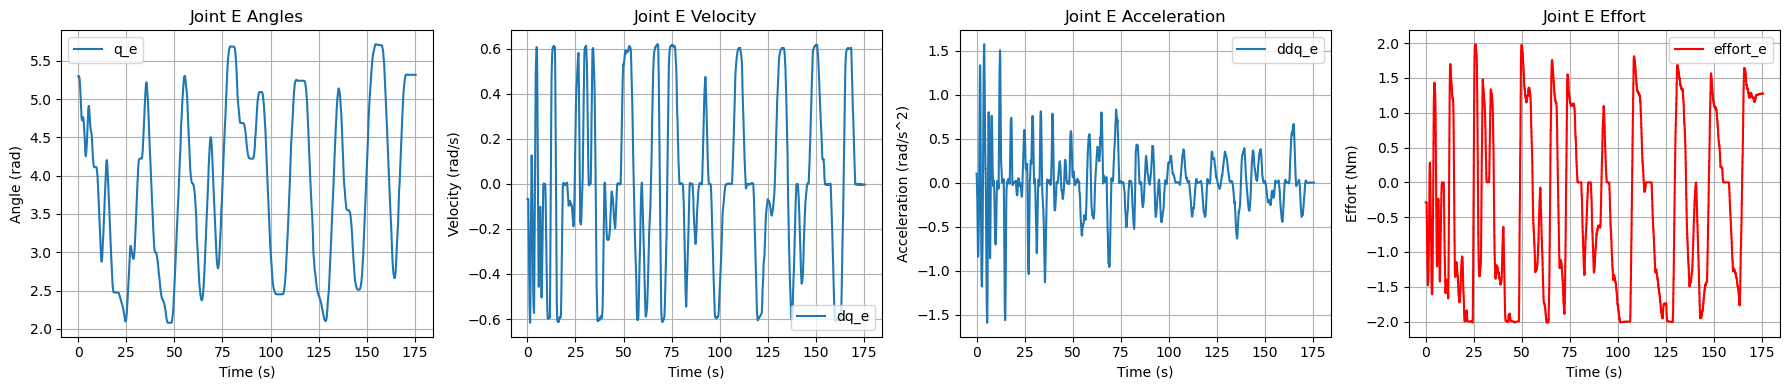

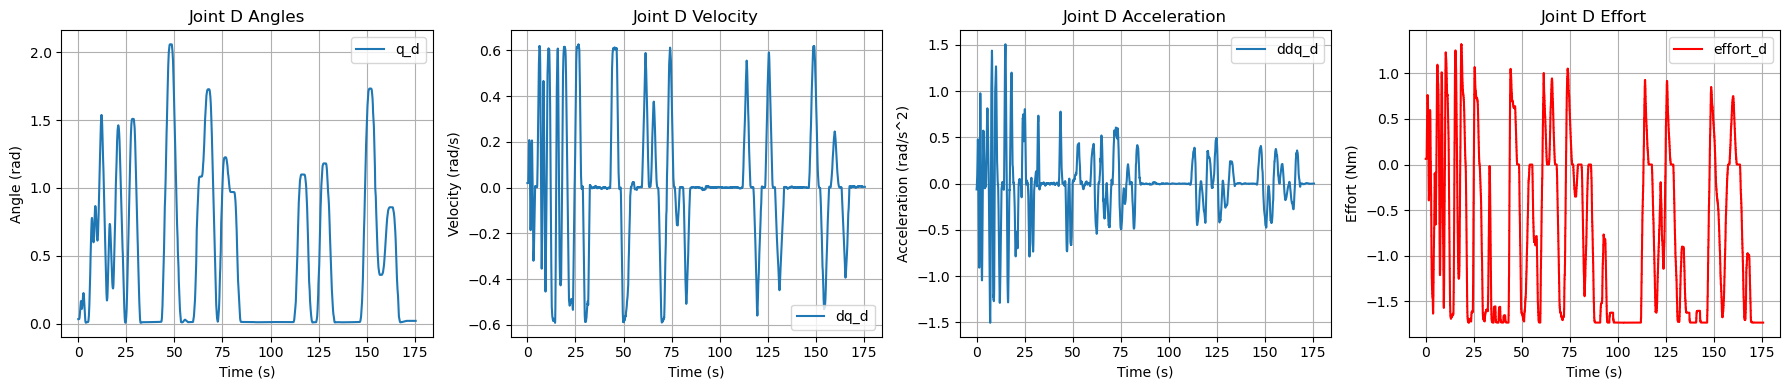

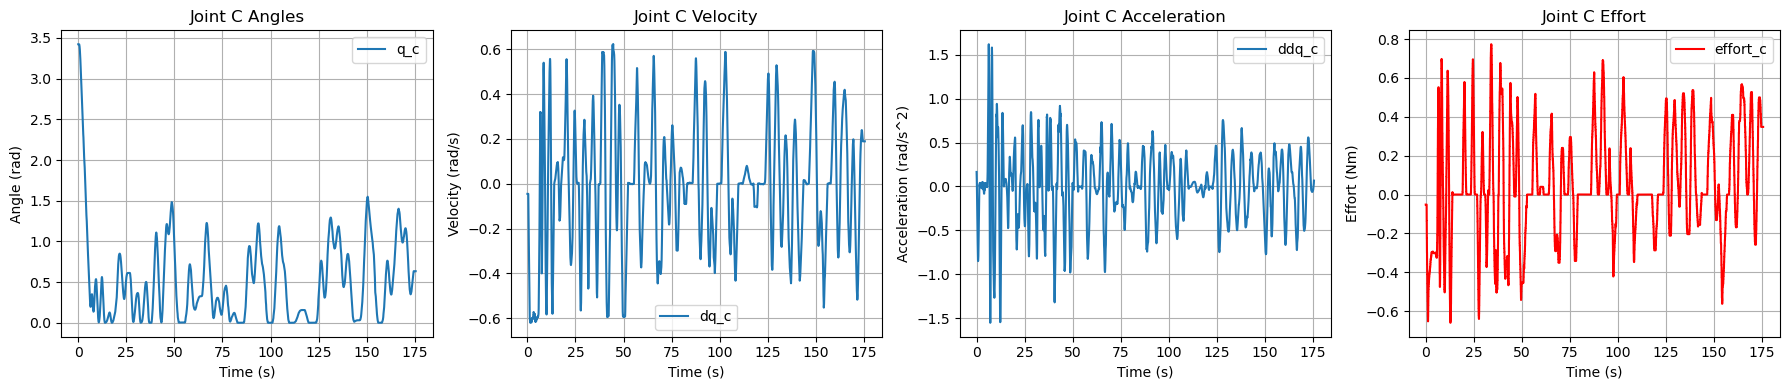

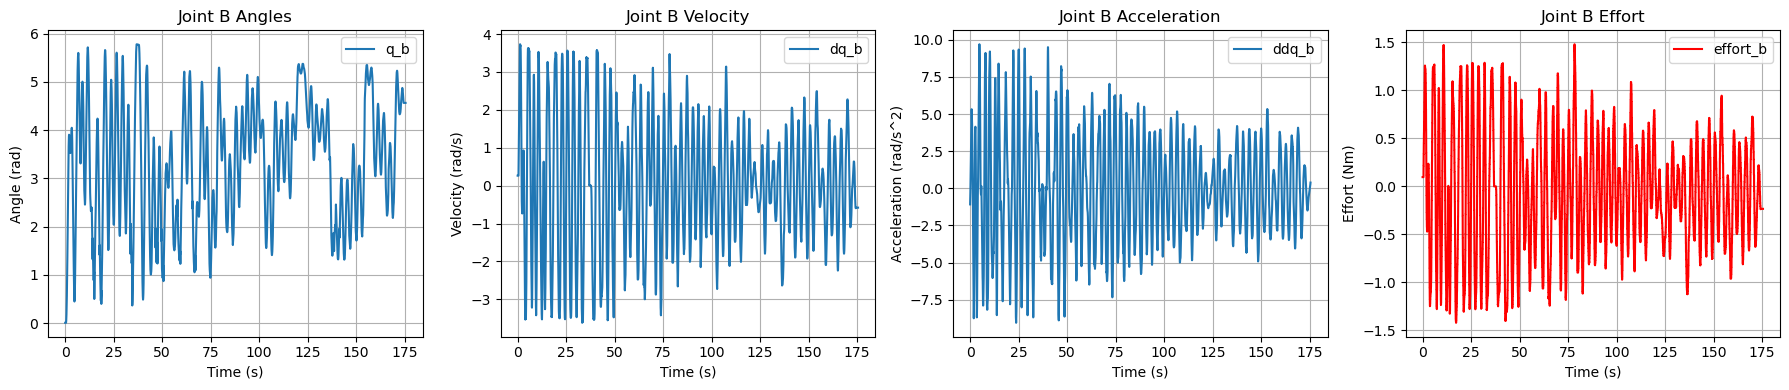

0.2549507479998283
0.2397224269952858
0.2706774139951449

Joint e
  m: 0.194
  mc: [-0, -0, -0]
  c = mc/m: [-0, -0, -0]
  I_bar:
    [0.7101, -0, -0]
    [-0, 0.7101, -0]
    [-0, -0, 1.99576e-06]
  fv: 2.3957, fc: 0, fs: -0
  min eig(J): 9.979e-07

Joint d
  m: 0.429
  mc: [-0.0429, 0.0196649, 0.0429]
  c = mc/m: [-0.1, 0.045839, 0.1]
  I_bar:
    [0.110179, -0.0332241, -0.083035]
    [-0.0332241, 0.183331, -0.0383631]
    [-0.083035, -0.0383631, 0.104292]
  fv: 2.23596, fc: 0, fs: -0
  min eig(J): 9.979e-07

Joint c
  m: 0.115
  mc: [0.00288078, 0.00723517, 0.00916435]
  c = mc/m: [0.0250503, 0.0629145, 0.07969]
  I_bar:
    [0.118956, -0.000396113, -0.0213905]
    [-0.000396113, 0.122364, -0.00177228]
    [-0.0213905, -0.00177228, 0.00434412]
  fv: 0.819671, fc: 0, fs: -0
  min eig(J): 9.979e-07

Joint b
  m: 0.333
  mc: [0.00216416, -0.00119077, 0.00807347]
  c = mc/m: [0.00649899, -0.00357588, 0.0242446]
  I_bar:
    [0.0192511, 0.0014879, 0.000453687]
    [0.0014879, 0.0256548, 

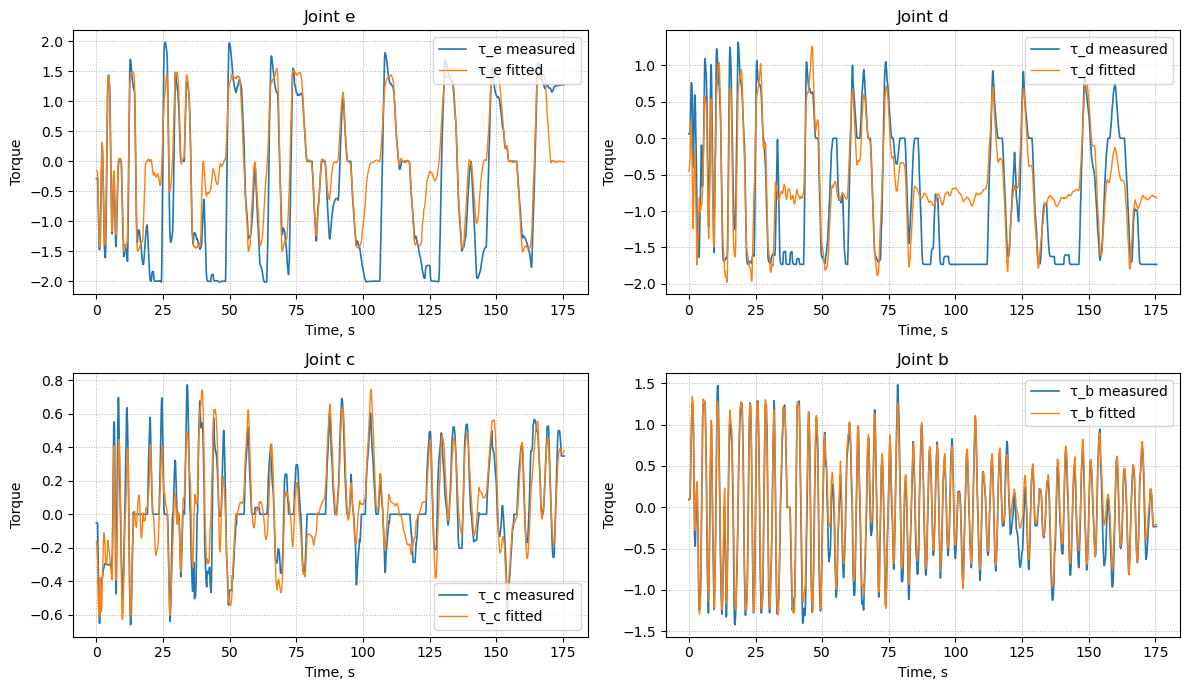

MSE per joint, order ['e', 'd', 'c', 'b'] : [0.69797154 0.31224561 0.01755704 0.01619007]
MAE per joint, order ['e', 'd', 'c', 'b'] : [0.54437117 0.45527303 0.10186958 0.09524039]
NRMSE per joint, order ['e', 'd', 'c', 'b'] : [0.20876714 0.18301229 0.09240862 0.04383678]


In [1]:
%run dynamic_parameter_identification.ipynb

In [2]:
LINK_GROUP_LEN = 13

def off(j: int, k: int) -> int:
    return j * LINK_GROUP_LEN + k

def unpack_block(beta, j: int):
    th = np.asarray(beta, dtype=float).reshape(-1)
    m   = th[off(j, 0)]
    mcx = th[off(j, 1)]
    mcy = th[off(j, 2)]
    mcz = th[off(j, 3)]
    Ixx = th[off(j, 4)]
    Iyy = th[off(j, 5)]
    Izz = th[off(j, 6)]
    Ixy = th[off(j, 7)]
    Ixz = th[off(j, 8)]
    Iyz = th[off(j, 9)]
    fv  = th[off(j, 10)]
    fc  = th[off(j, 11)]
    fs  = th[off(j, 12)]
    return m, np.array([mcx, mcy, mcz]), (Ixx, Iyy, Izz, Ixy, Ixz, Iyz), (fv, fc, fs)

# smoke
m0, mc0, I0, fr0 = unpack_block(theta_hat, 0)
print("joint0 m:", m0)
print("joint0 mc:", mc0)
print("joint0 fr:", fr0)


joint0 m: 0.19399999958185
joint0 mc: [-0. -0. -0.]
joint0 fr: (2.3956975612030047, 0.0, -0.0)


In [3]:
def log_likelihood(theta, A, b):
    theta = np.asarray(theta, dtype=float).reshape(-1)
    A = np.asarray(A, dtype=float)
    b = np.asarray(b, dtype=float).reshape(-1)

    if not np.all(np.isfinite(theta)):
        return -np.inf

    n, p = A.shape
    if theta.size != p + 1:
        return -np.inf

    beta = theta[:p]
    log_sigma = theta[p]

    model = A @ beta
    if not np.all(np.isfinite(model)):
        return -np.inf

    sigma2 = np.exp(2.0 * log_sigma)
    if (not np.isfinite(sigma2)) or (sigma2 <= 0.0):
        return -np.inf

    resid = b - model
    if not np.all(np.isfinite(resid)):
        return -np.inf

    return -0.5 * (n * np.log(2.0 * np.pi * sigma2) + (resid @ resid) / sigma2)

theta_test = np.r_[theta_hat, np.log(1.0)]
print("ll_test:", log_likelihood(theta_test, Y_big, tau_big))


ll_test: -18734.496946537147


In [4]:
def numeric_J_from_block(beta_block):
    th = np.asarray(beta_block, dtype=float).reshape(-1)
    m   = th[0]
    mcx, mcy, mcz = th[1], th[2], th[3]
    Ixx, Iyy, Izz = th[4], th[5], th[6]
    Ixy, Ixz, Iyz = th[7], th[8], th[9]

    I_bar = np.array([[Ixx, Ixy, Ixz],
                      [Ixy, Iyy, Iyz],
                      [Ixz, Iyz, Izz]], dtype=float)
    mc = np.array([[mcx], [mcy], [mcz]], dtype=float)

    J_ul = 0.5 * np.trace(I_bar) * np.eye(3) - I_bar
    J = np.block([[J_ul, mc],
                  [mc.T, np.array([[m]], dtype=float)]])
    return J

def min_eig_sym(M):
    M = 0.5 * (M + M.T)
    return float(np.min(np.linalg.eigvalsh(M)))


In [5]:
def log_prior(theta, estimator, theta_ref, mass_tol=1e-6, zero_tol=1e-6, eps_psd_target=1e-8):
    theta = np.asarray(theta, dtype=float).reshape(-1)
    p = int(getattr(estimator, "p", len(theta_ref)))
    link_len = int(getattr(estimator, "link_group_len", 13))
    n_joints = int(getattr(estimator, "n_joints", p // link_len))
    fixed_blocks = getattr(estimator, "_fixed_blocks", {}) or {}

    if theta.size != p + 1:
        return -np.inf

    beta = theta[:p]
    if not np.all(np.isfinite(beta)):
        return -np.inf

    masses = np.asarray(getattr(estimator, "masses", [np.nan] * n_joints), dtype=float).reshape(-1)
    if masses.size != n_joints or not np.all(np.isfinite(masses)):
        return -np.inf

    for j in range(n_joints):
        base = j * link_len
        block = beta[base:base + link_len]

        if not np.all(np.isfinite(block)):
            return -np.inf
        if j in fixed_blocks:
            continue

        # hard pins
        if abs(block[0] - masses[j]) > mass_tol:
            return -np.inf
        if block[10] < 0.0:
            return -np.inf
        if abs(block[11]) > zero_tol:
            return -np.inf
        if abs(block[12]) > zero_tol:
            return -np.inf

        # hard PSD
        J = numeric_J_from_block(block)
        if min_eig_sym(J) < eps_psd_target:
            return -np.inf

        # hard J1 triangle inequalities
        Ixx, Iyy, Izz = block[4], block[5], block[6]
        if Ixx > Iyy + Izz + 1e-12:
            return -np.inf
        if Iyy > Ixx + Izz + 1e-12:
            return -np.inf
        if Izz > Ixx + Iyy + 1e-12:
            return -np.inf

    return 0.0


def log_probability(theta, estimator, A, b, theta_ref):
    try:
        lp = log_prior(theta, estimator, theta_ref)
        if not np.isfinite(lp):
            return -np.inf
        ll = log_likelihood(theta, A, b)
        if not np.isfinite(ll):
            return -np.inf
        return lp + ll
    except Exception:
        return -np.inf
    
theta_test = np.r_[theta_hat, np.log(1.0)]
print("logpost_test:", log_probability(theta_test, estimator, Y_big, tau_big, theta_hat))


logpost_test: -18734.496946537147


In [6]:
def build_initial_walkers(theta_ref, estimator, nwalkers=128, log_sigma0=np.log(1.0), seed=7):
    rng = np.random.default_rng(seed)
    p = int(getattr(estimator, "p", len(theta_ref)))
    link_len = int(getattr(estimator, "link_group_len", 13))
    n_joints = int(getattr(estimator, "n_joints", p // link_len))
    fixed_blocks = getattr(estimator, "_fixed_blocks", {}) or {}

    theta_ref = np.asarray(theta_ref, dtype=float).reshape(-1)

    walkers = []
    for _ in range(nwalkers):
        beta = theta_ref.copy()

        for j in range(n_joints):
            if j in fixed_blocks:
                continue
            idx_fv = j * link_len + 10
            beta[idx_fv] = beta[idx_fv] + rng.normal() * 0.05
            if beta[idx_fv] < 0.0:
                beta[idx_fv] = abs(beta[idx_fv])

        log_sigma = log_sigma0 + rng.normal() * 0.1
        walkers.append(np.r_[beta, log_sigma])

    return np.array(walkers, dtype=float)

In [7]:
nwalkers = 128
def run_mcmc_for_manipulator():  
    init_pos = build_initial_walkers(theta_hat, estimator, nwalkers=nwalkers, seed=7)
    ndim = init_pos.shape[1]

    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        log_probability,
        args=(estimator, Y_big, tau_big, theta_hat),
    )

    sampler.run_mcmc(init_pos, nsteps, progress=True, skip_initial_state_check=True)
    return sampler

In [8]:
import os
import numpy as np
import emcee

# Alpha MCMC cache/run block, matching the dory_mcmc pattern
nsteps=200000
filename = f"alpha_mcmc_results_{nsteps}.npz"

if os.path.exists(filename):
    print("Loading cached MCMC results...")
    data = np.load(filename, allow_pickle=True)
    samples = data["samples"]
    flat_samples = data["flat_samples"]
    beta_map = data["beta_map"]
    names = list(data["names"]) if "names" in data.files else None

else:
    print("Running MCMC...")
    sampler = run_mcmc_for_manipulator()
    samples = sampler.get_chain()
    flat_samples = sampler.get_chain(discard=200, thin=5, flat=True)

    p = int(getattr(estimator, "p", len(theta_hat)))
    beta_map = np.asarray(theta_hat, dtype=float).reshape(-1)[:p]

    # build names once and save, like dory saves metadata
    link_len = int(getattr(estimator, "link_group_len", 13))
    n_joints = int(getattr(estimator, "n_joints", p // link_len))
    joint_names = getattr(estimator, "joint_names", None)
    if joint_names is None or len(joint_names) != n_joints:
        joint_names = [f"j{j}" for j in range(n_joints)]

    param_names = ["m","mcx","mcy","mcz","Ixx","Iyy","Izz","Ixy","Ixz","Iyz","fv","fc","fs"]
    names = []
    for jn in joint_names:
        for pn in param_names:
            names.append(f"{jn}.{pn}")
    names = names[:p]

    np.savez_compressed(
        filename,
        samples=samples,
        flat_samples=flat_samples,
        beta_map=beta_map,
        names=np.array(names, dtype=object),
        discard=200,
        thin=5,
        nsteps=nsteps,
        nwalkers=nwalkers,
    )
    print("Saved MCMC results to", filename)

print("samples shape:", samples.shape)
print("flat_samples shape:", flat_samples.shape)
print("beta_map shape:", beta_map.shape)
if names is not None:
    print("names:", len(names))


Loading cached MCMC results...
samples shape: (200000, 128, 53)
flat_samples shape: (5114880, 53)
beta_map shape: (52,)
names: 52


      name       opt                           post_ci
0     j0.m  0.194000              0.194 [0.194, 0.194]
1   j0.mcx -0.000000                         0 [-0, 0]
2   j0.mcy -0.000000                         0 [-0, 0]
3   j0.mcz -0.000000                         0 [-0, 0]
4   j0.Ixx  0.710100                 0.71 [0.71, 0.71]
5   j0.Iyy  0.710100                 0.71 [0.71, 0.71]
6   j0.Izz  0.000002              2e-06 [2e-06, 2e-06]
7   j0.Ixy -0.000000                         0 [-0, 0]
8   j0.Ixz -0.000000                         0 [-0, 0]
9   j0.Iyz -0.000000                         0 [-0, 0]
10   j0.fv  2.395698                  2.67 [2.6, 2.74]
11   j0.fc  0.000000                          0 [0, 0]
12   j0.fs -0.000000                         0 [-0, 0]
13    j1.m  0.429000              0.429 [0.429, 0.429]
14  j1.mcx -0.042900        -0.0429 [-0.0429, -0.0429]
15  j1.mcy  0.019665           0.0197 [0.0197, 0.0197]
16  j1.mcz  0.042900           0.0429 [0.0429, 0.0429]
17  j1.Ixx

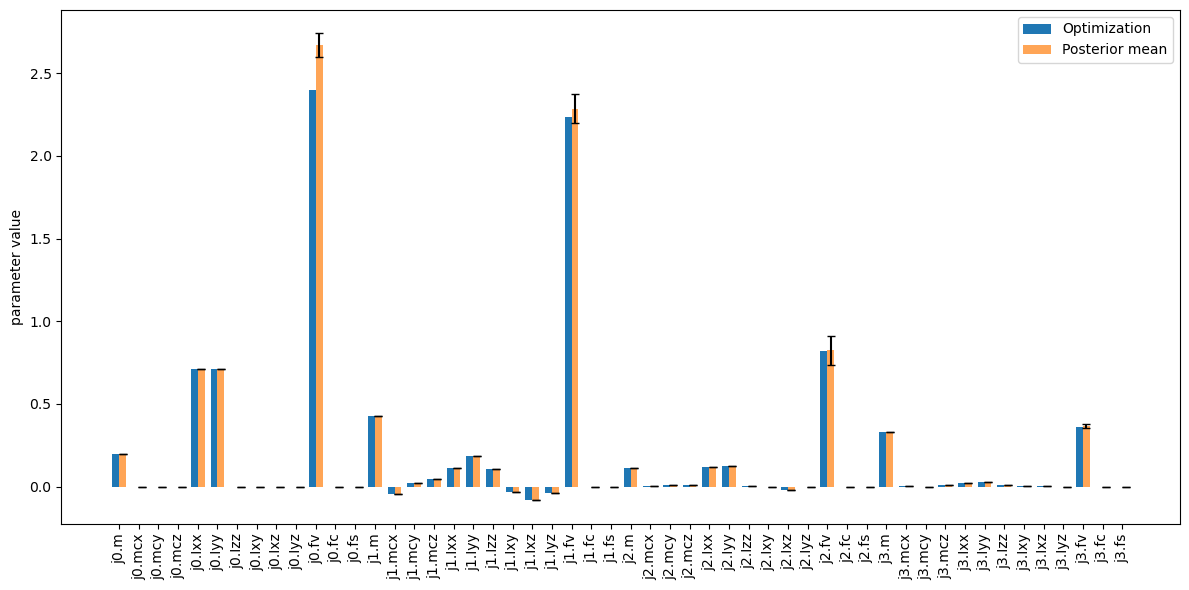

In [9]:
import pandas as pd
import matplotlib.pyplot as plt


p = int(getattr(estimator, "p", len(theta_hat)))
beta_map = np.asarray(theta_hat, dtype=float).reshape(-1)[:p]          # optimized point
beta_samples = np.asarray(flat_samples, dtype=float)[:, :p]            # posterior samples

assert beta_samples.shape[1] == p

link_len = int(getattr(estimator, "link_group_len", 13))
n_joints = int(getattr(estimator, "n_joints", p // link_len))
joint_names = getattr(estimator, "joint_names", None)
if joint_names is None or len(joint_names) != n_joints:
    joint_names = [f"j{j}" for j in range(n_joints)]

param_names = ["m","mcx","mcy","mcz","Ixx","Iyy","Izz","Ixy","Ixz","Iyz","fv","fc","fs"]
names = []
for jn in joint_names:
    for pn in param_names:
        names.append(f"{jn}.{pn}")

names = names[:p]
assert len(names) == p

# --- Posterior summary stats ---
beta_mean = np.mean(beta_samples, axis=0)
beta_q16, beta_q84 = np.percentile(beta_samples, [16, 84], axis=0)

# --- 4) DataFrame with CI strings ---
df = pd.DataFrame({
    "name": names,
    "opt": beta_map,
    "post_mean": beta_mean,
    "post_q16": beta_q16,
    "post_q84": beta_q84,
})

df["post_ci"] = df.apply(
    lambda row: f"{row['post_mean']:.3g} [{row['post_q16']:.3g}, {row['post_q84']:.3g}]",
    axis=1,
)

print(df[["name", "opt", "post_ci"]])

# --- 5) Plot optimization vs posterior mean with error bars ---
indices = np.arange(p)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(indices - width/2, beta_map, width, label="Optimization")
ax.bar(indices + width/2, beta_mean, width, label="Posterior mean", alpha=0.7)

lower_err = np.maximum(beta_mean - beta_q16, 0.0)
upper_err = np.maximum(beta_q84 - beta_mean, 0.0)
yerr = np.vstack([lower_err, upper_err])

print("min lower_err:", float(lower_err.min()))
print("min upper_err:", float(upper_err.min()))

ax.errorbar(
    indices + width/2,
    beta_mean,
    yerr=yerr,
    fmt="none",
    ecolor="black",
    capsize=3,
)

ax.set_xticks(indices)
ax.set_xticklabels(names, rotation=90)
ax.set_ylabel("parameter value")
ax.legend()
fig.tight_layout()
plt.show()


In [10]:
def draw_posterior_samples_alpha(N=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    p = int(getattr(estimator, "p", len(theta_hat)))   # 52 for alpha
    idx = np.random.randint(flat_samples.shape[0], size=N)
    betas = flat_samples[idx, :p]

    print("Drawn alpha betas shape:", betas.shape)

    # append 6 zeros for vehicle base dof
    padding = np.zeros((betas.shape[0], 6), dtype=float)

    samples = np.concatenate([betas, padding], axis=1)
    return samples

# example usage
posterior_samples = draw_posterior_samples_alpha(80000, seed=42)
print("posterior_samples shape:", posterior_samples.shape)  # (80000, 58)
print(posterior_samples[0, :])

# save binary file for downstream C++ / CUDA loaders
posterior_samples.astype(np.float64).tofile("posterior_alpha.bin")

Drawn alpha betas shape: (80000, 52)
posterior_samples shape: (80000, 58)
[ 1.94000000e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  7.10109586e-01  7.10109586e-01  1.99576149e-06 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  2.62474269e+00  0.00000000e+00
 -0.00000000e+00  4.29000000e-01 -4.29000003e-02  1.96649101e-02
  4.29000003e-02  1.10178508e-01  1.83331277e-01  1.04292121e-01
 -3.32240937e-02 -8.30350362e-02 -3.83631263e-02  2.16848261e+00
  0.00000000e+00 -0.00000000e+00  1.14999999e-01  2.88077923e-03
  7.23516749e-03  9.16434754e-03  1.18956416e-01  1.22363853e-01
  4.34411664e-03 -3.96112974e-04 -2.13904668e-02 -1.77228242e-03
  8.46920244e-01  0.00000000e+00 -0.00000000e+00  3.32999998e-01
  2.16416476e-03 -1.19076924e-03  8.07346553e-03  1.92510932e-02
  2.56548460e-02  7.17220917e-03  1.48789886e-03  4.53687373e-04
 -1.09861913e-03  3.54609576e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00